# Lifelogs from March 6-9 2018
Natalia Vélez, December 2019–January 2020

In this notebook:

* Load, clean up lifelog data from March 6–9 2018 (corresponding to the first release after the start of the logs)
* Prepare inputs for subsequent analyses (family trees, migration patterns)
* Aggregate lifespan, causes of death

This notebook uses data from March 6–9, 2018, which corresponds to the first release after the start of the logs.

In [ ]:
%matplotlib inline

import os, re, glob, random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj
from tqdm import tqdm_notebook
from ast import literal_eval as make_tuple

sns.set_context('paper')

Helper functions:

In [2]:
gsearch = lambda *args: glob.glob(opj(*args))
str_extract = lambda pattern, s: re.search(pattern, s).group(0)

## Clean up data

Find data files:

In [3]:
data_dir = '../data/'
data_files = gsearch(data_dir, 'publicLifeLogData', '**', '2018_03March_0*.txt')
data_files.sort()
print('%i files found' % len(data_files))
print(*[os.path.basename(f) for f in data_files], sep='\n')

40 files found
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_07_Wednesday

Load all files:

In [4]:
data_list = []
empty_files = []
for f in tqdm_notebook(data_files):
    try:
        tmp_server = str_extract('(?<=lifeLog_)[a-zA-Z0-9]+', f)
        tmp_d = pd.read_csv(f, sep =' ', header=None)
        tmp_d.insert(0, 'server', tmp_server)
        data_list.append(tmp_d)
    except:
        empty_files.append(f)

In [5]:
raw_data = pd.concat(data_list)
raw_data.head()

,server,0,1,2,3,4,5,6,7,8
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,F,"(-49,607)",noParent,pop=1,chain=1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,M,"(-49,607)",parent=36490,pop=2,chain=2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,F,"(-70,74)",noParent,pop=3,chain=1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,M,"(-70,74)",parent=36492,pop=4,chain=2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,F,"(-37,95)",noParent,pop=5,chain=1


Deaths:

In [6]:
death_raw = raw_data[raw_data.iloc[:,1] == 'D'].copy().reset_index(drop=True)
death_raw.head()

,server,0,1,2,3,4,5,6,7,8
0,server1,D,1520559304,36496,ff3129a2dce20bda9df31ffcfcbfd3230977ea4e,age=14.34,F,"(67,36)",disconnect,pop=23
1,server1,D,1520559304,36497,14f418eedc7f854167ffb4ca5244ad95cee53f2a,age=0.31,F,"(67,36)",disconnect,pop=23
2,server1,D,1520559313,36499,ab7258ebd0ce2b381650386df6821220ac4783ca,age=0.40,M,"(-95,66)",hunger,pop=31
3,server1,D,1520559320,36503,74a504ee16b67a3c1f8649ac6f37543ffc072786,age=0.45,F,"(111,-16)",hunger,pop=32
4,server1,D,1520559321,36522,643ccc3f451b5b7cc46137e8e3f3ccb209fe83ff,age=14.16,F,"(19,-73)",disconnect,pop=32


Births:

In [7]:
birth_raw = raw_data[raw_data.iloc[:,1] == 'B'].copy().reset_index(drop=True)
birth_raw.head()

,server,0,1,2,3,4,5,6,7,8
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,F,"(-49,607)",noParent,pop=1,chain=1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,M,"(-49,607)",parent=36490,pop=2,chain=2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,F,"(-70,74)",noParent,pop=3,chain=1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,M,"(-70,74)",parent=36492,pop=4,chain=2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,F,"(-37,95)",noParent,pop=5,chain=1


### Clean up data

In [8]:
shared_header = ['server', 'event', 'timestamp', 'playerID', 'hash', 'uniqueID', 'age', 'sex',
                 'location', 'parent', 'cause_of_death', 'killer', 'pop', 'chain']

#### Deaths

In [9]:
death_data = death_raw.copy()
# Insert missing columns
death_data.insert(5, 'uniqueID', np.nan)
death_data.insert(9, 'parent', np.nan)
death_data.insert(12, 'chain', np.nan)
death_data.insert(11, 'killer', np.nan)
death_data.columns = shared_header

for i, row in tqdm_notebook(death_data.iterrows(), total=death_data.shape[0]):
    age = str_extract('(?<=age=)\d+\.\d+', row['age'])
    age = float(age)
    
    pop = str_extract('(?<=pop=)[0-9]+', row['pop'])
    pop = int(pop)
    
    death_data.at[i, 'age'] = age
    death_data.at[i, 'pop'] = pop

Clean up IDs,  locations, causes of death

In [10]:
# Unique ID: Player ID + hash
death_data['uniqueID'] = death_data.apply(lambda row: '%s_%s' % (row['playerID'], row['hash']),
                                          axis=1)

# Locations
death_data['location'] = death_data['location'].apply(make_tuple)

# Check for murdered players
murderers = death_data['cause_of_death'].str.extract(r'(?<=killer_)([0-9]+)', expand=False)
death_data['cause_of_death'] = death_data['cause_of_death'].str.replace("killer_[0-9]+", "murdered")
death_data['killer'] = murderers

print(death_data['cause_of_death'].unique())
print(death_data['killer'].unique()[:10])

death_data.head()

['disconnect' 'hunger' 'murdered' 'oldAge']
[nan '36567' '36710' '36753' '36947' '37230' '37908' '38079' '38237'
 '18112']


,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,server1,D,1520559304,36496,ff3129a2dce20bda9df31ffcfcbfd3230977ea4e,36496_ff3129a2dce20bda9df31ffcfcbfd3230977ea4e,14.34,F,"(67, 36)",NaN,disconnect,NaN,23,NaN
1,server1,D,1520559304,36497,14f418eedc7f854167ffb4ca5244ad95cee53f2a,36497_14f418eedc7f854167ffb4ca5244ad95cee53f2a,0.31,F,"(67, 36)",NaN,disconnect,NaN,23,NaN
2,server1,D,1520559313,36499,ab7258ebd0ce2b381650386df6821220ac4783ca,36499_ab7258ebd0ce2b381650386df6821220ac4783ca,0.4,M,"(-95, 66)",NaN,hunger,NaN,31,NaN
3,server1,D,1520559320,36503,74a504ee16b67a3c1f8649ac6f37543ffc072786,36503_74a504ee16b67a3c1f8649ac6f37543ffc072786,0.45,F,"(111, -16)",NaN,hunger,NaN,32,NaN
4,server1,D,1520559321,36522,643ccc3f451b5b7cc46137e8e3f3ccb209fe83ff,36522_643ccc3f451b5b7cc46137e8e3f3ccb209fe83ff,14.16,F,"(19, -73)",NaN,disconnect,NaN,32,NaN


#### Births

In [29]:
birth_data = birth_raw.copy()
# Insert missing columns
birth_data.insert(5, 'uniqueID', np.nan)
birth_data.insert(6, 'age', np.nan)
birth_data.insert(10, 'cause_of_death', np.nan)
birth_data.insert(11, 'killer', np.nan)
birth_data.columns = shared_header

for i, row in tqdm_notebook(birth_data.iterrows(), total=birth_data.shape[0]):    
    pop = str_extract('(?<=pop=)[0-9]+', row['pop'])
    pop = int(pop)
    
    chain = str_extract('(?<=chain=)[0-9]+', row['chain'])
    chain = int(chain)
    
    birth_data.at[i, 'pop'] = pop
    birth_data.at[i, 'chain'] = chain

birth_data.head()

,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,NaN,NaN,F,"(-49,607)",noParent,NaN,NaN,1,1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,NaN,NaN,M,"(-49,607)",parent=36490,NaN,NaN,2,2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,NaN,NaN,F,"(-70,74)",noParent,NaN,NaN,3,1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,NaN,NaN,M,"(-70,74)",parent=36492,NaN,NaN,4,2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,NaN,NaN,F,"(-37,95)",noParent,NaN,NaN,5,1


Clean up IDs, locations, parents:

In [32]:
birth_data['uniqueID'] = birth_data.apply(lambda row: '%s_%s' % (row['playerID'], row['hash']), axis=1)
birth_data['location'] = birth_data['location'].apply(make_tuple)
birth_data['parent'] = birth_data['parent'].str.extract(r'(?<=parent=)([0-9]+)')

birth_data.head()

,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,36490_49483e9224e4ccdb5af274bb71bb1e3de9aeedea,NaN,F,"(-49, 607)",NaN,NaN,NaN,1,1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,36491_50edfe49ea709e8764321ae12643c19ebf172c5f,NaN,M,"(-49, 607)",36490,NaN,NaN,2,2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,36492_f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,NaN,F,"(-70, 74)",NaN,NaN,NaN,3,1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,36493_26541162d8aeb20f1c633000ade50cabc23df1c5,NaN,M,"(-70, 74)",36492,NaN,NaN,4,2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,36494_f623c5fbea396330c89487a06c5613b6cf80f65e,NaN,F,"(-37, 95)",NaN,NaN,NaN,5,1


#### Save outputs

In [34]:
lifelog_data = pd.concat([death_data, birth_data])
lifelog_data = lifelog_data.sort_values(by=['server', 'timestamp'])
lifelog_data = lifelog_data.reset_index(drop=True)

lifelog_data.head()

,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,36490_49483e9224e4ccdb5af274bb71bb1e3de9aeedea,NaN,F,"(-49, 607)",NaN,NaN,NaN,1,1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,36491_50edfe49ea709e8764321ae12643c19ebf172c5f,NaN,M,"(-49, 607)",36490,NaN,NaN,2,2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,36492_f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,NaN,F,"(-70, 74)",NaN,NaN,NaN,3,1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,36493_26541162d8aeb20f1c633000ade50cabc23df1c5,NaN,M,"(-70, 74)",36492,NaN,NaN,4,2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,36494_f623c5fbea396330c89487a06c5613b6cf80f65e,NaN,F,"(-37, 95)",NaN,NaN,NaN,5,1


In [37]:
out_file = 'outputs/lifelogs_201803_data.csv'
lifelog_data.to_csv(out_file, sep='\t', index=False)

## Census: How many players?

In [42]:
lifelog_data.groupby('event').agg({'event': 'count'})

,event
event,
B,79782
D,79553


## Deaths: How and when do people die?

Age of death:

Plotting 79553 deaths


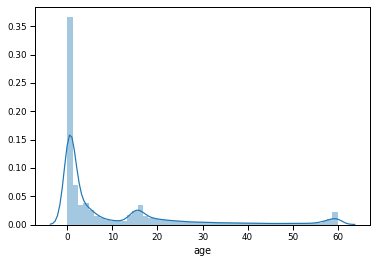

In [38]:
print('Plotting %i deaths' % len(death_data))
sns.distplot(death_data['age'])

Frequency of causes of death:

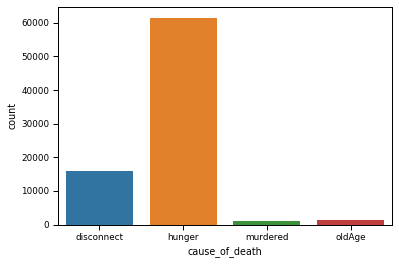

In [39]:
sns.countplot(x='cause_of_death', data=death_data)

Age by cause of death:

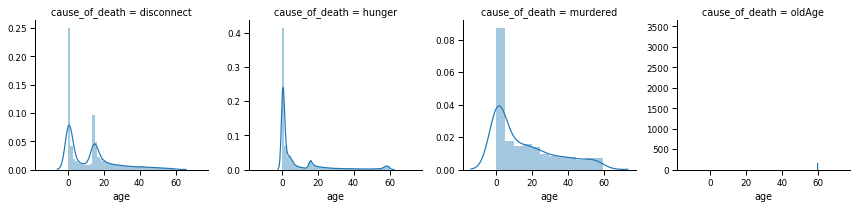

In [40]:
g = sns.FacetGrid(death_data, col='cause_of_death', sharey=False)
g.map(sns.distplot, "age")

Location of deaths:

In [ ]:
death_loc = death_causes.copy()
death_loc = death_loc[['timestamp', 'playerID', 'location', 'cause_of_death']]
death_loc['location'] = death_loc['location'].apply(make_tuple)
death_loc[['x', 'y']] = pd.DataFrame(death_loc['location'].tolist(), index=death_loc.index)  
death_loc.head()

In [ ]:
plt.figure(figsize=(30,30))
g = sns.FacetGrid(death_loc, col='cause_of_death', col_wrap=2, hue='cause_of_death')
g.map(sns.scatterplot, 'x', 'y', alpha=0.25)

<div style="background-color:#ffaaaa"><p>The code below will be moved to 2_3_lineages and 2_4_migration</p></div>

## Migration: How far do people die from their place of birth?

Match births and deaths:

In [ ]:
birth_loc = birth_data[['server', 'playerID', 'hash', 'location']]
birth_loc = birth_loc.rename(columns={'location': 'birth'})
birth_loc.head()

In [ ]:
death_loc = death_data[['server', 'playerID', 'hash', 'age', 'location']]
death_loc = death_loc.rename(columns={'location': 'death'})
death_loc.head()

Distance:

In [ ]:
dist_fun = lambda row: np.linalg.norm(row['death']-row['birth'])

life_loc =  birth_loc.merge(death_loc)
life_loc['age'] = life_loc['age'].astype(np.float)
life_loc['birth'] = life_loc['birth'].apply(make_tuple)
life_loc['birth'] = life_loc['birth'].apply(np.array)

life_loc['death'] = life_loc['death'].apply(make_tuple)
life_loc['death'] = life_loc['death'].apply(np.array)

life_loc['distance'] = life_loc.apply(dist_fun, axis=1)

life_loc.head()

In [ ]:
sns.distplot(life_loc['distance'])
np.median(life_loc['distance'])

## Births: Charting family trees

### Prepare data

In [ ]:
graph_data = birth_data[['playerID', 'parent']].copy()
graph_data = graph_data.rename(columns={"playerID": "child"})
graph_data['child'] = graph_data['child'].astype(np.float)
graph_data['parent'] = np.where(graph_data['parent'] == 'noParent', 
                                np.nan,
                                graph_data['parent'].str.replace('parent=', ''))
graph_data['parent'] = graph_data['parent'].astype(np.float)
graph_data.head()

#### Data quality checks

How many nodes?

In [ ]:
graph_data.nunique()

Are the entries in "children" a subset of "parent"?

In [ ]:
children = graph_data['child'].unique()
parents = graph_data['parent'].unique()
parents = parents[~np.isnan(parents)]

In [ ]:
np.all([p in children for p in parents])

Draw graph:

In [ ]:
family_graph = nx.from_pandas_edgelist(graph_data, source='parent', target='child')

In [ ]:
nx.draw_random(family_graph, with_labels=False)